# Crop Disease Detection: Model Training with ResNet50

**Project Overview**: Train a CNN using transfer learning to classify crop diseases from leaf images (PlantVillage dataset). Includes augmentation, class weights, and Grad-CAM for interpretability.

**Author**: SANCHAY MAITY | **Date**: October 17, 2025 | **Version**: 1.0

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import cv2
from tqdm import tqdm
plt.style.use('seaborn-v0_8')

# Paths and constants
DATA_DIR = 'data/plantvillage/plantvillage dataset/color'
IMG_SIZE = (224, 224)  # ResNet50 input size
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 38
MODEL_PATH = 'models/resnet50_crop_disease.h5'

# Verify GPU (optional)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [2]:
# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Class weights for imbalance
classes = np.array(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)
class_weight_dict = dict(enumerate(class_weights))

print(f"Found {train_generator.samples} training images, {val_generator.samples} validation images")
print(f"Class weights computed for {len(class_weight_dict)} classes")

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 43456 training images, 10849 validation images
Class weights computed for 38 classes


In [3]:
# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,656,294 (94.06 MB)

 Trainable params: 1,068,582 (4.08 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# Train
os.makedirs('models', exist_ok=True)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    verbose=1
)

# Save model
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

C:\Users\sm01\PycharmProjects\PythonProjectcrop-disease-detection\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5106s 4s/step - accuracy: 0.0831 - loss: 3.4697 - val_accuracy: 0.1169 - val_loss: 3.2913
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5493s 4s/step - accuracy: 0.1347 - loss: 3.2779 - val_accuracy: 0.1888 - val_loss: 3.2146
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5600s 4s/step - accuracy: 0.1901 - loss: 3.1030 - val_accuracy: 0.1605 - val_loss: 3.0150
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5615s 4s/step - accuracy: 0.2332 - loss: 2.9489 - val_accuracy: 0.2427 - val_loss: 2.8081
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5658s 4s/step - accuracy: 0.2513 - loss: 2.8348 - val_accuracy: 0.2715 - val_loss: 2.7082
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5703s 4s/step - accuracy: 0.2616 - loss: 2.7631 - val_accuracy: 0.2526 - val_loss: 2.6897
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5552s 4s/step - accuracy: 0.2679 - loss: 2.7012 - val_accuracy: 0.2630 - val_loss: 2.6897
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4878s 4s/step - accuracy: 0.2743 -

Model saved to models/resnet50_crop_disease.h5


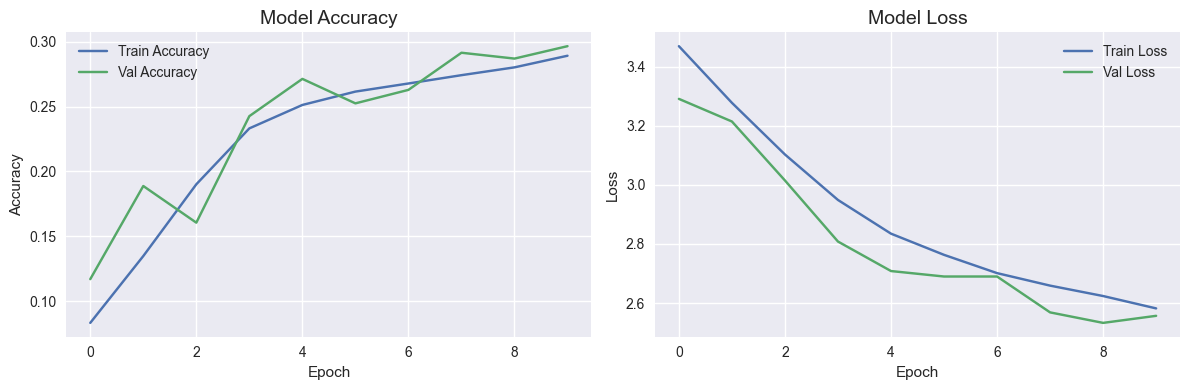

340/340 ━━━━━━━━━━━━━━━━━━━━ 987s 3s/step

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.0526    0.0238    0.0328       126
                                 Apple___Black_rot     0.0833    0.0323    0.0465       124
                          Apple___Cedar_apple_rust     0.0449    0.2545    0.0763        55
                                   Apple___healthy     0.1880    0.0760    0.1082       329
                               Blueberry___healthy     0.2037    0.1467    0.1705       300
          Cherry_(including_sour)___Powdery_mildew     0.1986    0.5429    0.2908       210
                 Cherry_(including_sour)___healthy     0.1229    0.5235    0.1991       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.2383    0.5490    0.3323       102
                       Corn_(maize)___Common_rust_     0.4050    0.8151    0.5411       238
             

C:\Users\sm01\PycharmProjects\PythonProjectcrop-disease-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sm01\PycharmProjects\PythonProjectcrop-disease-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sm01\PycharmProjects\PythonProjectcrop-disease-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

In [9]:
# python
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Ensure output directory exists
os.makedirs('models', exist_ok=True)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('models/training_plots.png', dpi=300)
plt.show()

# Classification report
val_generator.reset()
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Use class names ordered by their numeric indices
class_names = [name for name, idx in sorted(val_generator.class_indices.items(), key=lambda x: x[1])]

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

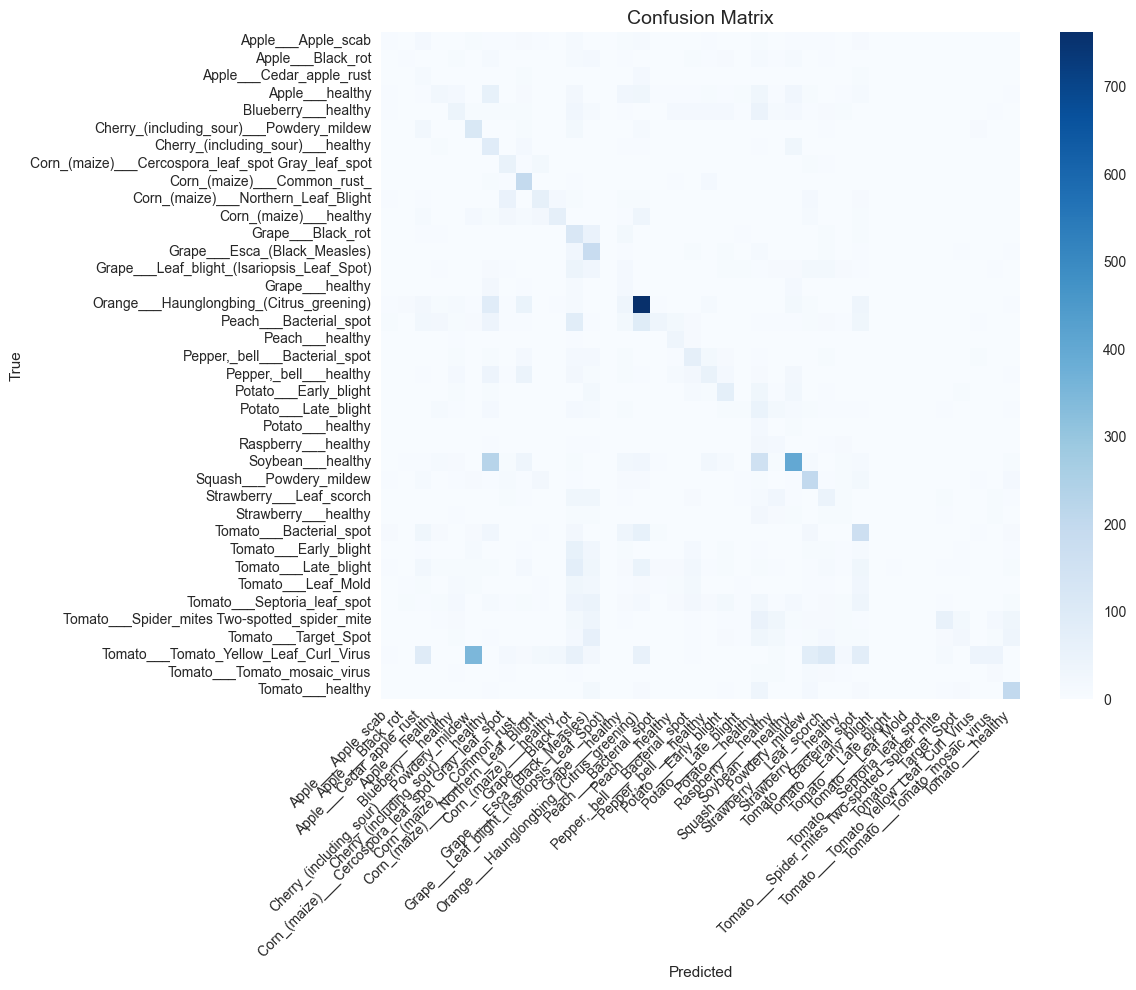

In [10]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('models/confusion_matrix.png', dpi=300)
plt.show()

In [16]:
import os

# Corrected DATA_DIR based on project structure
DATA_DIR = 'data/plantvillage/plantvillage dataset/color'  # Adjust if needed
CLASSES = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"Classes loaded: {CLASSES[:5]}...")  # Verify first 5 classes

Classes loaded: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']...


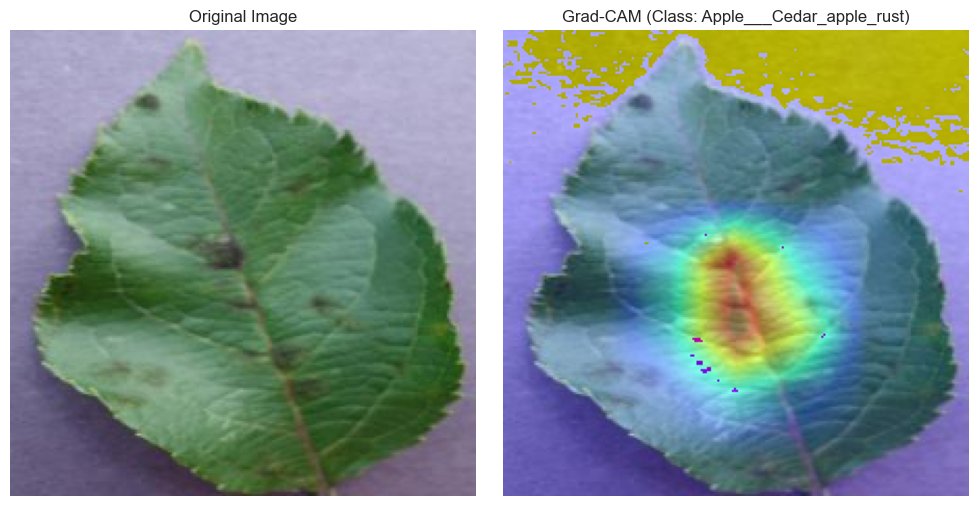

In [19]:
def get_gradcam_heatmap(img_path, model, last_conv_layer_name='conv5_block3_out'):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array / 255.0, axis=0)

    # Get last conv layer output and prediction
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array])  # Wrap input in list
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Superimpose heatmap
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title(f'Grad-CAM (Class: {list(val_generator.class_indices.keys())[class_idx]})')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('models/gradcam_sample.png', dpi=300)
    plt.show()

# Test Grad-CAM on a sample image
sample_img = os.path.join(DATA_DIR, CLASSES[0], os.listdir(os.path.join(DATA_DIR, CLASSES[0]))[0])
get_gradcam_heatmap(sample_img, model)